In [20]:
from typing import List

from langchain import hub
from langchain.agents import AgentExecutor, load_tools
from langchain.agents.format_scratchpad import format_log_to_str
from langchain.agents.output_parsers import ReActJsonSingleInputOutputParser
from langchain.callbacks.manager import CallbackManagerForRetrieverRun
from langchain.schema import BaseRetriever, Document
from langchain.tools.render import render_text_description
from langchain.tools.retriever import create_retriever_tool
from langchain_community.chat_models.fireworks import ChatFireworks
from langchain_community.utilities.arxiv import ArxivAPIWrapper
from langchain_core.pydantic_v1 import BaseModel

MODEL_ID = "accounts/fireworks/models/mixtral-8x7b-instruct"

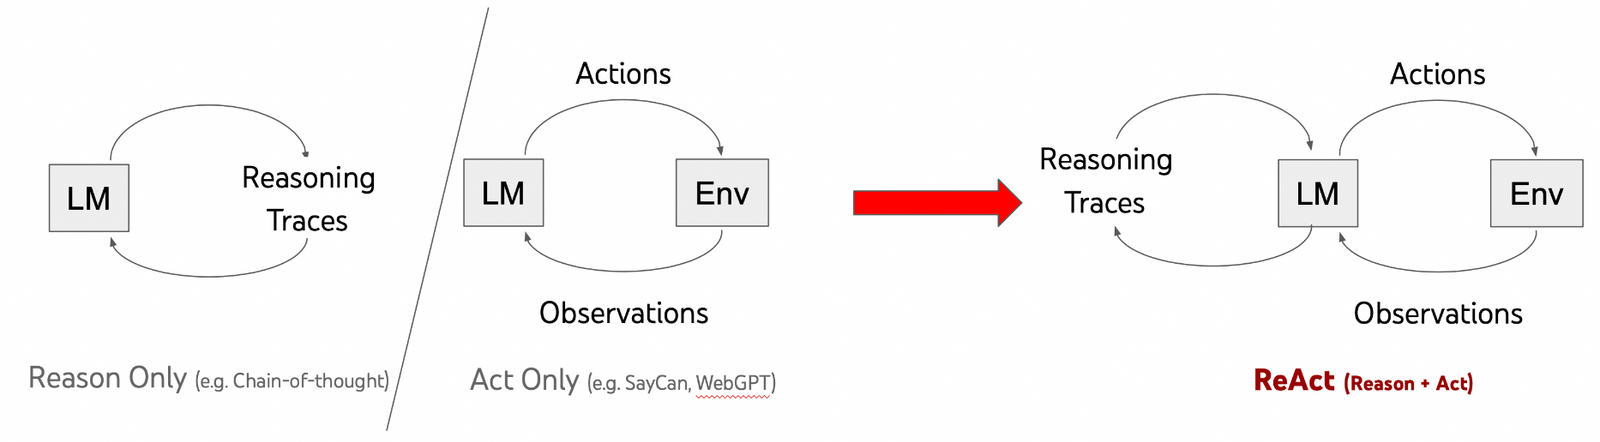

# Set .env file

```
FIREWORKS_API_KEY=XXX
GOOGLE_API_KEY=XXX
GOOGLE_CSE_ID=XXX
```

In [21]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


# Tools

## Google Search Tool

In [22]:
from langchain.tools import Tool
from langchain_community.utilities import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper()


search_tool = Tool(
    name="Google Search Snippets",
    description="Search Google for recent results.",
    func=search.run,
)

## Arxiv Tool to retrieve science papers

In [23]:
class ArxivRetriever(BaseRetriever, ArxivAPIWrapper):
    """`Arxiv` retriever.

    It wraps load() to get_relevant_documents().
    It uses all ArxivAPIWrapper arguments without any change.
    """

    get_full_documents: bool = False

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        try:
            if self.is_arxiv_identifier(query):
                results = self.arxiv_search(
                    id_list=query.split(),
                    max_results=self.top_k_results,
                ).results()
            else:
                results = self.arxiv_search(  # type: ignore
                    query[: self.ARXIV_MAX_QUERY_LENGTH], max_results=self.top_k_results
                ).results()
        except self.arxiv_exceptions as ex:
            return [Document(page_content=f"Arxiv exception: {ex}")]
        docs = [
            Document(
                page_content=result.summary,
                metadata={
                    "Published": result.updated.date(),
                    "Title": result.title,
                    "Authors": ", ".join(a.name for a in result.authors),
                },
            )
            for result in results
        ]
        return docs

# # Set up tool(s)
description = (
    "A wrapper around Arxiv.org "
    "Useful for when you need to answer questions about Physics, Mathematics, "
    "Computer Science, Quantitative Biology, Quantitative Finance, Statistics, "
    "Electrical Engineering, Economics and other researcher's papers"
    "from scientific articles on arxiv.org. "
    "Input should be a search query."
)
arxiv_tool = create_retriever_tool(ArxivRetriever(), "arxiv", description)
tools = [arxiv_tool]


In [19]:

# Set up LLM
llm = ChatFireworks(
    model=MODEL_ID,
    model_kwargs={
        "temperature": 0,
        "max_tokens": 2048,
        "top_p": 1,
    },
)

tools = load_tools([
    "llm-math", 
    #"wikipedia",
    #"arxiv",
], llm=llm)
tools.extend([arxiv_tool])

## React Agent Type

In [ ]:
# setup ReAct style prompt
prompt = hub.pull("hwchase17/react-json")
prompt = prompt.partial(
    tools=render_text_description(tools),
    tool_names=", ".join([t.name for t in tools]),
)

# Stop generating more content and wait for the next instructions. 
# This mechanism is for integrating with tools, ensuring that each step in the processing pipeline is completed and incorporated before moving on.
model_with_stop = llm.bind(stop=["\nObservation"])
agent = (
    {
        # This part of the agent's definition specifies how to extract the actual input data from structured input object.
        "input": lambda x: x["input"],
        # This transformation is responsible for taking intermediate steps and converting them into a string format.
        "agent_scratchpad": lambda x: format_log_to_str(x["intermediate_steps"]),
    }
    | prompt
    | model_with_stop
    | ReActJsonSingleInputOutputParser()
)


class InputType(BaseModel):
    input: str

## Agent Excecutor

In [12]:
# instantiate AgentExecutor
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
).with_types(input_type=InputType)

In [14]:
question = """Your task is to write AWS CDK core to create a VPC with 2 public subnets in 2 different AZs.
"""
agent_executor.invoke({"input": question})



> Entering new AgentExecutor chain...
Question: How do I create a VPC with 2 public subnets in 2 different AZs using AWS CDK core?

Thought: To answer this question, I need to look up the AWS CDK documentation to understand the correct syntax and method calls for creating a VPC with public subnets in two different availability zones.

Action:
```json
{
  "action": "Google Search Snippets",
  "action_input": "aws cdk create vpc with 2 public subnets in 2 different azs"
}
```Jun 9, 2022 ... Is there a way to create (for example) one private subnet in AZ 1, one private subnet in AZ 2 and one public subnet in AZ 3 via CDK? Does ... Jun 28, 2019 ... Module Version: @aws-cdk/aws-ec2@0.36.2; OS: OSX Mojave; Language: TypeScript. Other Info: I've also hit the need to be able to filter by Name, ... Apr 13, 2023 ... 2 Answers 2 ... By default your VPC CIDR will be equally divided, 1 public and 1 private subnets will be created per AZ (source). As you're not ... ... 2 AZs, be sure to ... List o

{'input': 'Your task is to write AWS CDK core to create a VPC with 2 public subnets in 2 different AZs.\n',
 'output': 'To create a VPC with 2 public subnets in 2 different AZs using AWS CDK core, you can use the provided TypeScript code as a starting point. This code creates a new VPC with two public subnets in two different AZs and outputs the subnet IDs for further use.'}